In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd

In [0]:
spark = SparkSession.builder.appName("myapp").getOrCreate()

In [0]:
# Load the dataset into a DataFrame
df1 = spark.read.csv("/FileStore/tables/twitter_data.csv", header=True, inferSchema=True)

# Show the first 10 rows of the DataFrame
df1.show(10)
     

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|                                                                                               is upset that he ...|
|  0|1467810917|        Mon Apr 06 22:19:...|NO_QUERY|       mattycus|                                                                                               @Kenichan I dived...|
|  0|1467811184|        Mon Apr 06 22:19:...|NO_QUERY|        Ell

In [0]:
#Shape of data
print(df1.count(),len(df1.columns))


1599999 6


In [0]:
#Defining Column names
new_columns = ['sentiment', 'id', 'date', 'query', 'username', 'text']
df2 = df1.toDF(*new_columns)
df2.show()

+---------+----------+--------------------+--------+---------------+--------------------+
|sentiment|        id|                date|   query|       username|                text|
+---------+----------+--------------------+--------+---------------+--------------------+
|        0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|        0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|        0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|        0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|        0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|        0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|        0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|        0|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|        0

In [0]:
# Check for null values in all columns
df2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in  df2.columns]).show()

In [0]:
df2.printSchema()

root
 |-- sentiment: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- username: string (nullable = true)
 |-- text: string (nullable = true)



In [0]:
#for verification
df_data=df2.groupBy('sentiment').count().sort(desc('count'))
df_data.show()

+---------+------+
|sentiment| count|
+---------+------+
|        4|800000|
|        0|799999|
+---------+------+



In [0]:
#Display processed Data
display(df2)

In [0]:
# Count the number of positive sentiment scores (0) in the dataset
num_pos_sentiments = df2.filter(df2['sentiment'] == 0).count()

# Count the number of negative sentiment scores (4) in the dataset
num_neg_sentiments = df2.filter(df2['sentiment'] == 4).count()

# Print the counts
print('Number of positive sentiments:', num_pos_sentiments)
print('Number of negative sentiments:', num_neg_sentiments)


Number of positive sentiments: 799999
Number of negative sentiments: 800000


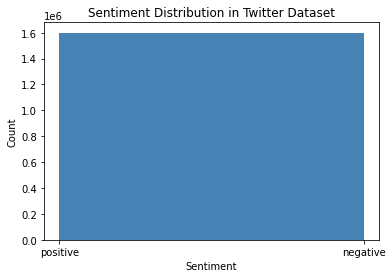

In [0]:
import matplotlib.pyplot as plt

# Extract the 'sentiment' column as a list of values
sentiment_values = df2.select('sentiment').rdd.flatMap(lambda x: x).collect()

# Create a dictionary to map 0 to 'positive' and 4 to 'negative'
sentiment_dict = {0: 'positive', 4: 'negative'}

# Use list comprehension to map sentiment values to 'positive' or 'negative'
sentiment_labels = [sentiment_dict[sentiment] for sentiment in sentiment_values]

# Plot a histogram of the sentiment values with two bins, one for each label
plt.hist(sentiment_labels, bins=['positive', 'negative'], color='steelblue')

# Add x-axis and y-axis labels and a title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in Twitter Dataset')

# Show the histogram
plt.show()


Python interpreter will be restarted.
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
Python interpreter will be restarted.
Python interpreter will be restarted.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.0 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.0.1
    Not uninstalling pillow at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-7353c260-01d4-466f-ab68-805f2f922e7c
    Can't uninstall 'Pillow'. No files were found to uninstall.
Python interpreter will be restarted.


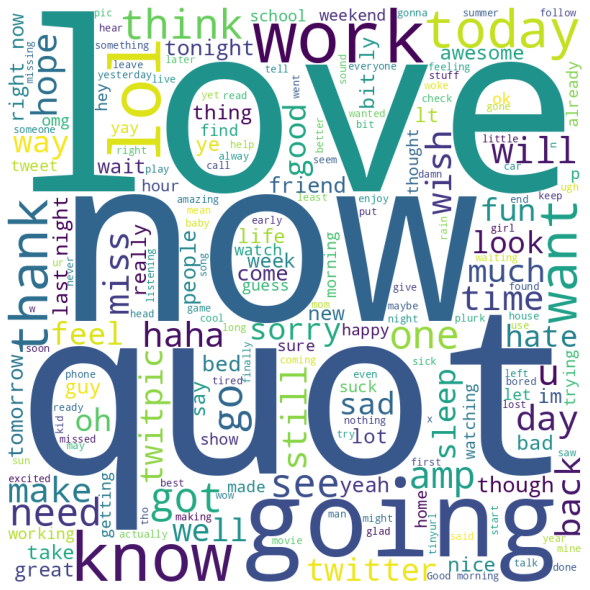

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Extract all text from the 'text' column as a list of strings and join them into a single string
all_text = ' '.join(df2.select('text').rdd.flatMap(lambda x: x).collect())

# Set stopwords to remove from the word cloud
stopwords = set(STOPWORDS)

# Generate a word cloud image with the most common words
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      stopwords = stopwords, 
                      min_font_size = 10).generate(all_text)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Show the word cloud
plt.show()


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

from pyspark.sql.functions import udf, col, lower, trim, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
def caseNormalization(df, column_name):
  df = df.withColumn(column_name, lower(col(column_name)))
  return df

In [0]:
df1 = spark.read.csv("/FileStore/tables/twitter_data.csv", header=True, inferSchema=True)
new_columns = ['sentiment', 'id', 'date', 'query', 'username', 'text']
df2 = df1.toDF(*new_columns)
df2 = caseNormalization(df2, 'text')
df2.show(5, truncate=False)

+---------+----------+----------------------------+--------+-------------+---------------------------------------------------------------------------------------------------------------+
|sentiment|id        |date                        |query   |username     |text                                                                                                           |
+---------+----------+----------------------------+--------+-------------+---------------------------------------------------------------------------------------------------------------+
|0        |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton|is upset that he can't update his facebook by texting it... and might cry as a result  school today also. blah!|
|0        |1467810917|Mon Apr 06 22:19:53 PDT 2009|NO_QUERY|mattycus     |@kenichan i dived many times for the ball. managed to save 50%  the rest go out of bounds                      |
|0        |1467811184|Mon Apr 06 22:19:57 PDT 2009|NO_QUERY|ElleC

In [0]:
def trimming(df, column_name):
  return df.withColumn(column_name, trim(col(column_name)))

In [0]:
df2 = trimming(df2, 'text')
df2.show(5, truncate=False)

+---------+----------+----------------------------+--------+-------------+---------------------------------------------------------------------------------------------------------------+
|sentiment|id        |date                        |query   |username     |text                                                                                                           |
+---------+----------+----------------------------+--------+-------------+---------------------------------------------------------------------------------------------------------------+
|0        |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton|is upset that he can't update his facebook by texting it... and might cry as a result  school today also. blah!|
|0        |1467810917|Mon Apr 06 22:19:53 PDT 2009|NO_QUERY|mattycus     |@kenichan i dived many times for the ball. managed to save 50%  the rest go out of bounds                      |
|0        |1467811184|Mon Apr 06 22:19:57 PDT 2009|NO_QUERY|ElleC

2.2 Filter Punctuation and Extra Whitespaces

In [0]:
def punctuation(df, column_name):
  df_ = df.withColumn(column_name, regexp_replace(col(column_name), "[^a-zA-Z\\s]", ""))
  return df_.withColumn(column_name, trim(regexp_replace(col(column_name), " +", " ")))

In [0]:
df2 = punctuation(df2, 'text')
df2.show(5, truncate=False)

+---------+----------+----------------------------+--------+-------------+--------------------------------------------------------------------------------------------------------+
|sentiment|id        |date                        |query   |username     |text                                                                                                    |
+---------+----------+----------------------------+--------+-------------+--------------------------------------------------------------------------------------------------------+
|0        |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton|is upset that he cant update his facebook by texting it and might cry as a result school today also blah|
|0        |1467810917|Mon Apr 06 22:19:53 PDT 2009|NO_QUERY|mattycus     |kenichan i dived many times for the ball managed to save the rest go out of bounds                      |
|0        |1467811184|Mon Apr 06 22:19:57 PDT 2009|NO_QUERY|ElleCTF      |my whole body feels itchy 

2.3 Tokenization

In [0]:
from pyspark.ml.feature import Tokenizer
def tokenize(df, column_name):
  tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
  return tokenizer.transform(df).cache()

In [0]:
df2 = tokenize(df2, 'text')
df2.show(5, truncate=False)

+---------+----------+----------------------------+--------+-------------+--------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------+
|sentiment|id        |date                        |query   |username     |text                                                                                                    |tokens                                                                                                                        |
+---------+----------+----------------------------+--------+-------------+--------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------+
|0        |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton|is up

2.4 StopWords Removal

In [0]:
from pyspark.ml.feature import StopWordsRemover
def stopword(df, tokens_column_name):
  stopwords_remover = StopWordsRemover(inputCol=tokens_column_name, outputCol="terms")
  return stopwords_remover.transform(df).cache()

In [0]:
df2 = stopword(df2, 'tokens')
df2.show(5)

+---------+----------+--------------------+--------+-------------+--------------------+--------------------+--------------------+
|sentiment|        id|                date|   query|     username|                text|              tokens|               terms|
+---------+----------+--------------------+--------+-------------+--------------------+--------------------+--------------------+
|        0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|[is, upset, that,...|[upset, cant, upd...|
|        0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|kenichan i dived ...|[kenichan, i, div...|[kenichan, dived,...|
|        0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|      ElleCTF|my whole body fee...|[my, whole, body,...|[whole, body, fee...|
|        0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|       Karoli|nationwideclass n...|[nationwideclass,...|[nationwideclass,...|
|        0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|     joy_wolf|kwesidei not the ...|[kw

Stemming (Snowball)

In [0]:
from nltk.stem.snowball import SnowballStemmer
def stem(df, terms_column_name):
  stemmer = SnowballStemmer(language="english")
  stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
  terms_stemmed_df = df.withColumn("terms_stemmed", stemmer_udf(terms_column_name)).cache()
  return terms_stemmed_df

df2 = stem(df2, 'terms')
df2.show(5)

+---------+----------+--------------------+--------+-------------+--------------------+--------------------+--------------------+--------------------+
|sentiment|        id|                date|   query|     username|                text|              tokens|               terms|       terms_stemmed|
+---------+----------+--------------------+--------+-------------+--------------------+--------------------+--------------------+--------------------+
|        0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|[is, upset, that,...|[upset, cant, upd...|[upset, cant, upd...|
|        0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|kenichan i dived ...|[kenichan, i, div...|[kenichan, dived,...|[kenichan, dive, ...|
|        0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|      ElleCTF|my whole body fee...|[my, whole, body,...|[whole, body, fee...|[whole, bodi, fee...|
|        0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|       Karoli|nationwideclass n...|[nation

3. Embedding

There are three alternatives Word2Vec, CountVectorizer and HashTF

3.1 Word2Vec

In [0]:
def word2vec(df, column_name="terms",random_seed=42,embedding_size=30, model=None):
  from pyspark.ml.feature import Word2Vec
  
  if model is None:
    word2vec = Word2Vec(vectorSize=embedding_size, minCount=5, inputCol=column_name, outputCol="features", seed=random_seed)
    model = word2vec.fit(df)
  features = model.transform(df).cache()
  
  return model, features

In [0]:
word2vecModel, twitter_w2v_df = word2vec(df2, column_name="terms_stemmed", embedding_size=100)
twitter_w2v_df.show(5)

+---------+----------+--------------------+--------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|sentiment|        id|                date|   query|     username|                text|              tokens|               terms|       terms_stemmed|            features|
+---------+----------+--------------------+--------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|[is, upset, that,...|[upset, cant, upd...|[upset, cant, upd...|[-0.0164007103691...|
|        0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|kenichan i dived ...|[kenichan, i, div...|[kenichan, dived,...|[kenichan, dive, ...|[0.00572521872818...|
|        0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|      ElleCTF|my whole body fee...|[my, whole, body,...|[whole, body, fee...|[whole, bod

3.2 CountVectorizer

In [0]:
from pyspark.ml.feature import HashingTF, CountVectorizer, IDF, NGram
from pyspark.ml import Pipeline

def extract_features(df, column_name="terms_stemmed", vocab_size=1000,n_gram_size=4,n_features=200,min_doc_freq=10,type='CountVectorizer',\
                    cv_model = None, idf_model = None, hashing_TF = None):
    # vocab_size : number of words to be retained as vocabulary
    # min_doc_freq : minimum number of documents a word has to appear in to be included in the vocabulary
    # n_features = 200 default embedding vector size
    
    ngrams = NGram(n=n_gram_size, inputCol=column_name, outputCol="ngrams")
    ngrams.transform(df)
    
    tf_features_df = None
    
    if(type == "CountVectorizer"):    
        if cv_model is None:
            cv = CountVectorizer(inputCol=column_name, outputCol="tf_features", vocabSize=vocab_size, minDF=min_doc_freq)
            cv_model = cv.fit(df)
        tf_features_df = cv_model.transform(df).cache()
    
    if(type == "HashingTF"):
        if hashing_TF is None:
            hashing_TF = HashingTF(inputCol=column_name, outputCol="tf_features", numFeatures=n_features)
        tf_features_df = hashing_TF.transform(df).cache()
    
    if idf_model is None:
        idf = IDF(inputCol="tf_features", outputCol="features")
        idf_model = idf.fit(tf_features_df)
    tf_idf_features_df = idf_model.transform(tf_features_df).cache()
    
    # We will return models for testing purposes in future
    return tf_idf_features_df, {'CountVectorizer' : cv_model, 'IDF' : idf_model, 'HashingTF' : hashing_TF}

In [0]:
twitter_cv_df, cv_models = extract_features(df2, type="CountVectorizer")
twitter_cv_df.show(5)

+---------+----------+--------------------+--------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|sentiment|        id|                date|   query|     username|                text|              tokens|               terms|       terms_stemmed|         tf_features|            features|
+---------+----------+--------------------+--------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|[is, upset, that,...|[upset, cant, upd...|[upset, cant, upd...|(1000,[9,11,79,18...|(1000,[9,11,79,18...|
|        0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|kenichan i dived ...|[kenichan, i, div...|[kenichan, dived,...|[kenichan, dive, ...|(1000,[1,10,222,3...|(1000,[1,10,222,3...|
|        0|1467811184|Mon Apr 06 22

3.3 HashingTF

In [0]:
twitter_hash_df, hash_models = extract_features(df2, type="HashingTF")
twitter_cv_df.show(5)

+---------+----------+--------------------+--------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|sentiment|        id|                date|   query|     username|                text|              tokens|               terms|       terms_stemmed|         tf_features|            features|
+---------+----------+--------------------+--------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|[is, upset, that,...|[upset, cant, upd...|[upset, cant, upd...|(1000,[9,11,79,18...|(1000,[9,11,79,18...|
|        0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|kenichan i dived ...|[kenichan, i, div...|[kenichan, dived,...|[kenichan, dive, ...|(1000,[1,10,222,3...|(1000,[1,10,222,3...|
|        0|1467811184|Mon Apr 06 22

4. Train Model

4.1 Word2Vec Model

In [0]:
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns

def train_lr_and_get_results(df, labelCol="sentiment", featuresCol="features", maxIter = 10, train_size=0.8, test_size=0.2,seed=42, regParam=0.1, elasticNetParam=0.2, lr_default=False,tolParam=1e-06):
    trainDF, testDF = df.randomSplit([train_size,test_size],seed)
    lr = None
    if lr_default:
        lr = LogisticRegression(labelCol = labelCol, featuresCol = featuresCol,maxIter = maxIter)
    else:
        lr = LogisticRegression(labelCol = labelCol, featuresCol = featuresCol,maxIter = maxIter).setRegParam(regParam).setElasticNetParam(elasticNetParam).setTol(tolParam)
    model = lr.fit(trainDF)
    predictions = model.transform(testDF)
    pred = predictions.toPandas()
    y_true = pred['sentiment'].astype('float')
    y_pred = pred['prediction']
    return y_true, y_pred, model

def get_f1_score(y_true, y_pred):
    average_f1 = (f1_score(y_true, y_pred, pos_label=0.0) +  f1_score(y_true, y_pred, pos_label=4.0)) / 2
    return average_f1

def grid_search_hyperparameter_tuning(df,regParams, elasticNetParams , tolParams,labelCol="sentiment", featuresCol="features", maxIter = 10):
    max_f1_score = 0
    best_params = {'regParam' : 0, 'elasticNetParam' : 0, 'lrModel' : None, 'tolParam' : None}
    y_true_best = None
    y_pred_best = None
    for regParam in regParams:
        for elasticNetParam in elasticNetParams:
            for tolParam in tolParams:
                y_true, y_pred, lrModel = train_lr_and_get_results(df, labelCol, featuresCol, regParam=regParam, elasticNetParam=elasticNetParam, tolParam=tolParam, maxIter=maxIter)
                f1_score = get_f1_score(y_true,y_pred)
                if f1_score > max_f1_score:
                    print(f"F1 Score: {f1_score} found with parameters regParam:{regParam} and elasticNetParam:{elasticNetParam}")
                    max_f1_score = f1_score
                    y_true_best = y_true
                    y_pred_best = y_pred
                    best_params = {'regParam' : regParam, 'elasticNetParam' : elasticNetParam, 'lrModel' : lrModel, 'tolParam' : tolParam}
    return y_true_best, y_pred_best, best_params


def print_heatmap(y_true, y_pred):
    sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt=  'd', cmap = 'Blues')

In [0]:
y_true, y_pred, best_params = grid_search_hyperparameter_tuning(twitter_w2v_df, regParams=[0.01, 0.05, 0.1], elasticNetParams=[0.2,0.6,0.8], tolParams=[1e-06, 1e-03],maxIter=20)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


F1 Score: 0.6988815714480012 found with parameters regParam:0.01 and elasticNetParam:0.2


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
At

In [0]:
best_params

In [0]:
lrModel = best_params['lrModel']
print(lrModel.explainParams())

In [0]:
best_params['lrModel'].save('./word2vec_best')

In [0]:
print(classification_report(y_true, y_pred))

In [0]:
print_heatmap(y_true, y_pred)

4.2 CountVectorizer

In [0]:
y_true, y_pred, best_params = grid_search_hyperparameter_tuning(twitter_cv_df, regParams=[0.01, 0.05, 0.1], elasticNetParams=[0.2,0.6,0.8], tolParams=[1e-06, 1e-03],maxIter=20)

In [0]:
best_params

In [0]:
best_params['lrModel'].save('./cv_best')

In [0]:
print(classification_report(y_true, y_pred))

In [0]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

In [0]:
print_heatmap(y_true, y_pred)

4.3 HashingTF

In [0]:
y_true, y_pred, best_params = grid_search_hyperparameter_tuning(twitter_hash_df, regParams=[0.01, 0.05, 0.1], elasticNetParams=[0.2,0.6,0.8], tolParams=[1e-06, 1e-03],maxIter=20)

In [0]:
best_params

In [0]:
best_params['lrModel'].save('./hashtf_best')

In [0]:
print(classification_report(y_true, y_pred))

In [0]:
print_heatmap(y_true, y_pred)